#          Mental Health sentiment analysis

### About the data


This dataset consists of labeled data across various mental health conditions, with the following distribution:

- **Normal**: 16,351 instances
- **Depression**: 15,404 instances
- **Suicidal**: 10,653 instances
- **Anxiety**: 3,888 instances
- **Bipolar**: 2,877 instances
- **Stress**: 2,669 instances
- **Personality Disorder**: 1,201 instances

It is a popular dataset on Kaggle, with various test accuracies, and from observation, hardly above 80% without some form of data augmentation. The purpose of this analysis is to train with transformers and different learning rates to assess performance improvement.

## install and import libraries
### load the dataset

In [2]:
!ls

'Combined Data.csv'   drive   sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! unzip '/content/archive (2).zip'

Archive:  /content/archive (2).zip
  inflating: Combined Data.csv       


In [7]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_nlp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")



Mental_health = pd.read_csv('Combined Data.csv', index_col= 0)

In [8]:
Mental_health = pd.read_csv('Combined Data.csv', index_col= 0)

In [9]:
Mental_health.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


#### Preprocessing and visualisation

In [10]:
print(Mental_health.info())

NaN_statement = Mental_health[Mental_health['statement'].isna()]['statement']

len(NaN_statement)

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None


362

In [11]:
Mental_health.dropna(inplace = True)# Remove NAN values

Mental_health.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     52681 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [12]:
# print the first statemnt of each status

_status = Mental_health['status'].unique()

for i in _status:
  print(Mental_health[Mental_health['status'] == i].iloc[0, 1],)
  print(Mental_health[Mental_health['status'] == i].iloc[0, 0])
  print('\n','---'* 50)



Anxiety
oh my gosh

 ------------------------------------------------------------------------------------------------------------------------------------------------------
Normal
Gr gr dreaming of ex crush to be my game, God

 ------------------------------------------------------------------------------------------------------------------------------------------------------
Depression
I recently went through a breakup and she said she still wants to be friends so I said I can try doing that but when she talks to me about things it always hurts. I just want to lose feelings so all this pain can stop it hurts so much and I cannot even cry about it. I do not want to hurt her because she said she does not want to never speak to me again but I do not know what to do here. When we were together she always hurt me so I do not know why I still love her. I wish we never met it would be much less painful How do I lose feelings?

 -----------------------------------------------------------------

Text(0, 0.5, 'status')

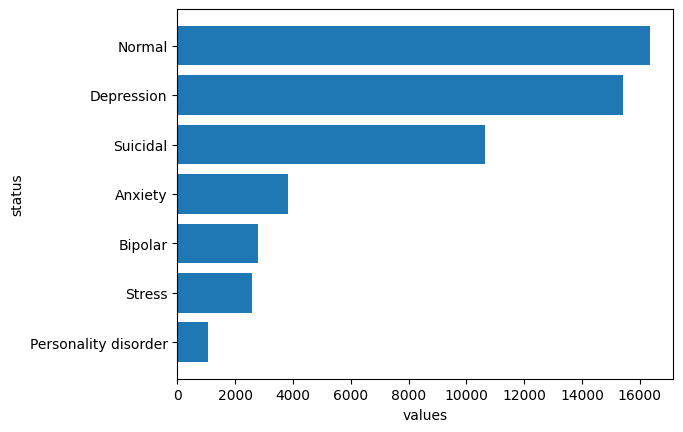

In [13]:
Status_ = Mental_health['status'].value_counts().index
values_ = Mental_health['status'].value_counts().values

plt.barh(Status_[::-1], values_[::-1])
plt.xlabel('values')
plt.ylabel('status')



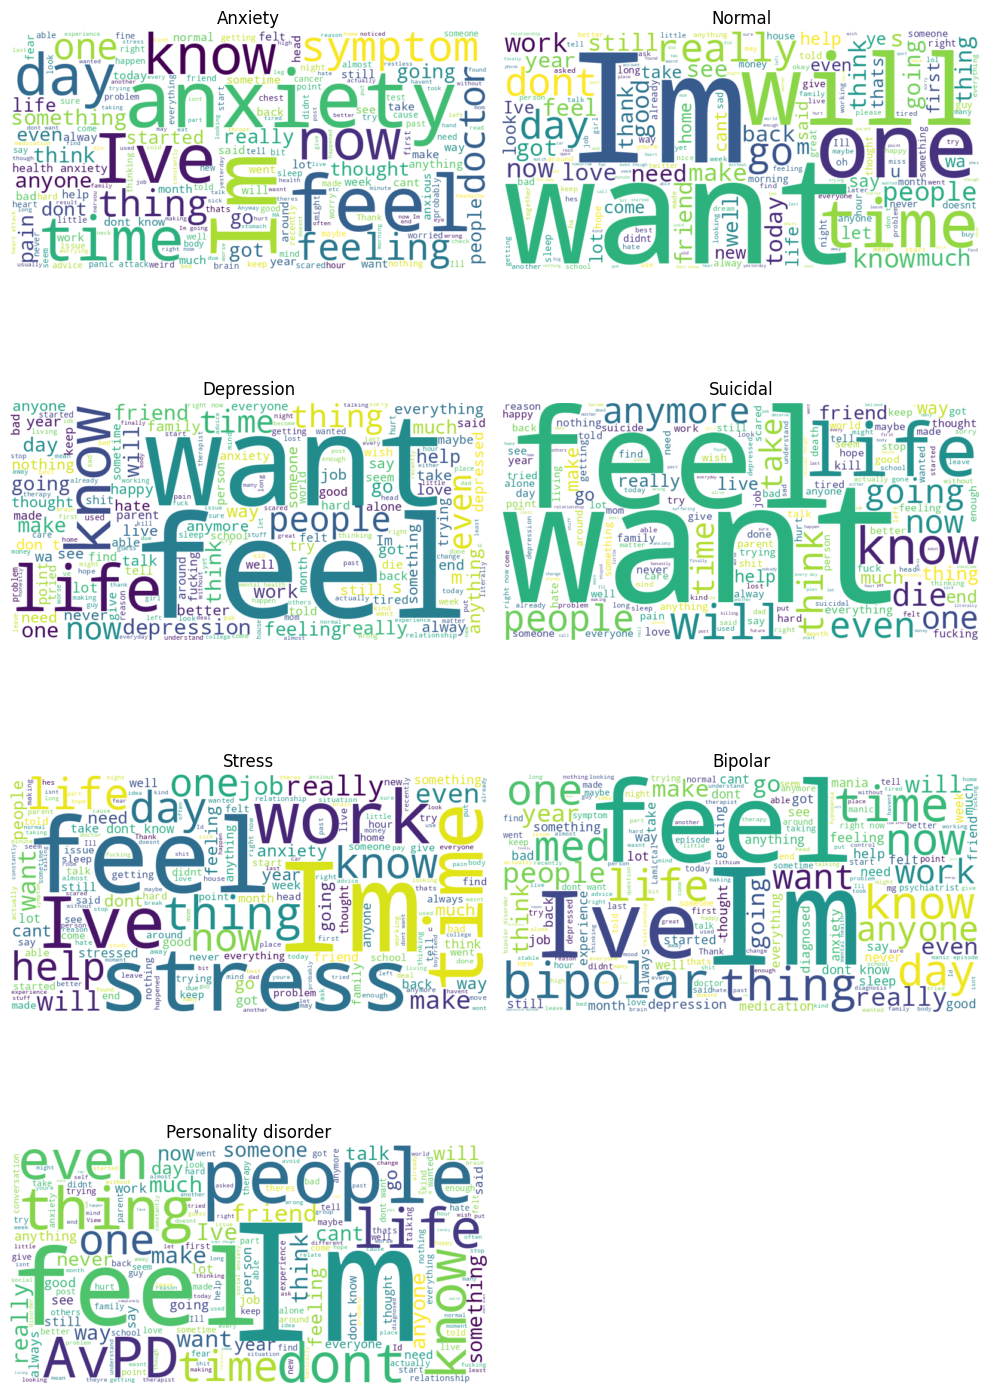

In [152]:
#Wordcloud for quick visualisation

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd



plt.figure(figsize=(10, 30))

for dig, i in enumerate( _status):
  text_data = " ".join(statement for statement in Mental_health.loc[Mental_health['status']== i, 'statement'])
  wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)
  axes = plt.subplot(4, 2, dig + 1)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(i)



plt.tight_layout()

# Adjust the vertical spacing between subplots (hspace controls vertical space)
plt.subplots_adjust(hspace = -0.8)

plt.show()






In [14]:
Mental_health['label'], names = pd.factorize(Mental_health['status'])# generating label encoder

for i, name in enumerate(names):
    print(f" {i}: {name}")




 0: Anxiety
 1: Normal
 2: Depression
 3: Suicidal
 4: Stress
 5: Bipolar
 6: Personality disorder


In [15]:
import re

def remove_non_english(text):
    return re.sub(r'[^a-zA-Z\s]', '', text) # removing non english words


# Apply preprocessing to the DataFrame column before vectorization
Mental_health['statement'] = Mental_health['statement'].apply(remove_non_english)

len(Mental_health['statement'])


52681

In [16]:
# some statememnt were very short and after removing non english works, few rows were empty and were removed in additon to 1 or 2 statement

Mental_health['sentence_length'] = Mental_health['statement'].apply(lambda x: len(x.split()))

Mental_health.loc[Mental_health['sentence_length'] == 0] # 6 empty statement

Mental_health.drop(Mental_health.loc[Mental_health['sentence_length'] < 3].index, inplace = True) # removing words less than 3, unlikely to have meaniful conversation

len(Mental_health['sentence_length'])

Mental_health.reset_index(drop = True, inplace = True)

Mental_health # lenght reduced from 52681 to 51669

,statement,status,label,sentence_length
0,oh my gosh,Anxiety,0,3
1,trouble sleeping confused mind restless heart ...,Anxiety,0,10
2,All wrong back off dear forward doubt Stay in ...,Anxiety,0,14
3,Ive shifted my focus to something else but Im ...,Anxiety,0,11
4,Im restless and restless its been a month now ...,Anxiety,0,14
...,...,...,...,...
51664,Nobody takes me seriously Ive M dealt with dep...,Anxiety,0,320
51665,selfishness I dont feel very good its like I ...,Anxiety,0,198
51666,Is there any way to sleep better I cant sleep ...,Anxiety,0,17
51667,Public speaking tips Hi all I have to give a p...,Anxiety,0,72



#### Spliting the dataset and convert to tensor
#### standardisation and tokenisation


In [17]:

X = Mental_health['statement']
y = Mental_health['label']

# Perform stratified split: 60% for training, 20% for validation and 20 for test
trainX, X_val, trainY, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.2, stratify=trainY, random_state=42)


# Combine the split data back into DataFrames for easier handling later
train_dataset = pd.DataFrame({'statement': X_train, 'label': y_train})
val_dataset = pd.DataFrame({'statement': X_val, 'label': y_val})
test_dataset = pd.DataFrame({'statement': X_test, 'label': y_test})




In [18]:
# convert to tf data set
train_dataset_ = tf.data.Dataset.from_tensor_slices((train_dataset['statement'].values, train_dataset['label'].values))
val_dataset_ = tf.data.Dataset.from_tensor_slices((val_dataset['statement'].values, val_dataset['label'].values))
test_dataset_ = tf.data.Dataset.from_tensor_slices((test_dataset['statement'].values, test_dataset['label'].values))

train_ds = train_dataset_.shuffle(buffer_size=1000)
val_ds = val_dataset_.shuffle(buffer_size=1000)
test_ds = test_dataset_.shuffle(buffer_size=1000)

In [19]:
# tokenization and vectorization
from tensorflow.keras import layers

max_length = 500
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int", output_sequence_length=max_length,) # text_vectorization apply lower() and removing punctuations from the data

text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)



In [20]:
train_inti = train_ds.map( lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
val_inti = val_ds.map( lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
test_inti = test_ds.map( lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)



###### First Training with python Transformer Encoder and positional Embedding Class. Suitable for stepwise understanding of transformer and positional embedding

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

vocab_size = 20000
sequence_length = 600
embed_dim = 100
num_heads = 2
dense_dim = 32

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # Multi-Head Attention Layer
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )

        # Dense Projection Sequential Layer
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])

        # Layer Normalization Layers
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            # Expand mask for attention heads
            mask = mask[:, tf.newaxis, :]

        # Multi-Head Attention
        attention_output = self.attention(inputs, inputs, attention_mask=mask)

        # Residual connection with LayerNorm
        proj_input = self.layernorm_1(inputs + attention_output)

        # Dense Projection with Residual connection
        proj_output = self.dense_proj(proj_input)

        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

   # def compute_mask(self, inputs, mask=None):
    #    return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

# Parameters
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32
train_inti = train_inti.batch(BATCH_SIZE)
val_inti = val_inti.batch(BATCH_SIZE)

# Inputs
inputs = keras.Input(shape=(None,), dtype="int64")

# Positional Embedding
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)

# Transformer Encoder
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

# Global Max Pooling, Dropout, and Dense Layer
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(7, activation="softmax")(x)

# Build Model
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Model Summary
model.summary()

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_encoder.keras", save_best_only=True)
]

# Train the Model
model.fit(train_inti, validation_data=val_inti, epochs=15, callbacks=callbacks)




Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ positional_embedding_6               │ (None, None, 256)           │       5,273,600 │
│ (PositionalEmbedding)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_87               │ (None, None, 256)           │         543,776 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_4               │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_142 (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,819,175 (22.20 MB)

 Trainable params: 5,819,175 (22.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 81s 146ms/step - accuracy: 0.4985 - loss: 1.6741 - val_accuracy: 0.7010 - val_loss: 0.7522
Epoch 2/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 72s 138ms/step - accuracy: 0.7142 - loss: 0.7473 - val_accuracy: 0.7451 - val_loss: 0.6554
Epoch 3/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 72s 139ms/step - accuracy: 0.7474 - loss: 0.6549 - val_accuracy: 0.7603 - val_loss: 0.6025
Epoch 4/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 71s 138ms/step - accuracy: 0.7709 - loss: 0.5972 - val_accuracy: 0.7690 - val_loss: 0.5816
Epoch 5/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 71s 137ms/step - accuracy: 0.7906 - loss: 0.5459 - val_accuracy: 0.7704 - val_loss: 0.5798
Epoch 6/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 70s 136ms/step - accuracy: 0.8080 - loss: 0.5036 - val_accuracy: 0.7679 - val_loss: 0.5817
Epoch 7/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 70s 135ms/step - accuracy: 0.8209 - loss: 0.4613 - val_accuracy: 0.7709 - val_loss: 0.5802
Epoch 8/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 69s 134ms/step - accuracy: 0.8397 - loss: 0

#### Started to overfit after 9 epoch with val accuracy of 77

#### Using the  KerasNpl library

In [21]:
# Input: tokenized and padded sequences

NUM_HEADS = 2
BATCH_SIZE = 64
EPOCHS = 10
max_length = 800
max_tokens = 20000
EMBED_DIM = 100
INTERMEDIATE_DIM = 32

input_ids = keras.Input(shape=(None,), dtype="int64", name="input_ids")

# Token and position embedding (with mask_zero=True to generate a padding mask)
x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=max_tokens,
    sequence_length=max_length,
    embedding_dim=EMBED_DIM,
    mask_zero=True  # This ensures a padding mask is generated
)(input_ids)

# Generate padding mask using a Lambda layer
# This wraps the TensorFlow operations within a Keras layer
#padding_mask = keras.layers.Lambda(lambda x: tf.cast(tf.not_equal(x, 0), dtype=tf.float32))(input_ids)

# First TransformerEncoder layer
x = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM,
    num_heads=NUM_HEADS
)(x)

# Second TransformerEncoder layer
x = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM,
    num_heads=NUM_HEADS
)(x)


# Pooling, Dropout, and Output Layer for classification
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(7, activation="softmax")(x)

# Final Model
transformer_classifier = keras.Model(input_ids, outputs, name="transformer_classifier")

In [22]:
transformer_classifier.summary()


Model: "transformer_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 100)      │      2,080,000 │ input_ids[0][0]        │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder       │ (None, None, 100)      │         47,332 │ token_and_position_em… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_1     │ (None, None, 100)      │         47,332 │ transformer_encoder[0… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 100)            │              0 │ transformer_encoder_1… │
│ (GlobalAveragePooling1D)  │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 100)            │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 7)              │            707 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,175,371 (8.30 MB)

 Trainable params: 2,175,371 (8.30 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:

train_inti = train_inti.batch(BATCH_SIZE)
val_inti = val_inti.batch(BATCH_SIZE)

transformer_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]) # learning rate of 0.0001


callbacks = [
 keras.callbacks.ModelCheckpoint("Online_Mental_Health.keras",
 save_best_only=True)]






transformer_classifier.fit(train_inti, epochs=EPOCHS, validation_data=val_inti, callbacks=callbacks)

Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 48s 69ms/step - accuracy: 0.5011 - loss: 1.3234 - val_accuracy: 0.6614 - val_loss: 0.8569
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.6794 - loss: 0.8221 - val_accuracy: 0.7446 - val_loss: 0.6664
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.7654 - loss: 0.6137 - val_accuracy: 0.7746 - val_loss: 0.5966
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.8126 - loss: 0.4964 - val_accuracy: 0.7769 - val_loss: 0.5915
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 27s 52ms/step - accuracy: 0.8494 - loss: 0.4040 - val_accuracy: 0.7694 - val_loss: 0.6401
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 27s 52ms/step - accuracy: 0.8821 - loss: 0.3325 - val_accuracy: 0.7587 - val_loss: 0.7121
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 27s 52ms/step - accuracy: 0.9093 - loss: 0.2569 - val_accuracy: 0.7485 - val_loss: 0.8029
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 27s 52ms/step - accuracy: 0.9353 - loss: 0.1955 - 

### Also val accuracy of 78% and started overfit.
Used adam optimizer with a learning rate of  0.0001, also worth to note the number of parameters where adjusted and reduced to 2million from 5 million from the 1st model

In [ ]:
NUM_HEADS = 2
BATCH_SIZE = 32
EPOCHS = 10
max_length = 500
max_tokens = 15000
EMBED_DIM = 100
INTERMEDIATE_DIM = 512

input_ids = keras.Input(shape=(None,), dtype="int64", name="input_ids")


x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=max_tokens,
    sequence_length=max_length,
    embedding_dim=EMBED_DIM)(input_ids)



x = keras_nlp.layers.TransformerEncoder(intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS)(inputs=x)
x = keras_nlp.layers.TransformerEncoder(intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS)(inputs=x)
x = keras_nlp.layers.TransformerEncoder(intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS)(inputs=x)




x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(7, activation="softmax")(x)

transformer_classifier = keras.Model(input_ids, outputs, name="transformer_classifier")


transformer_classifier.summary()


Model: "transformer_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding_13      │ (None, None, 100)           │       1,550,000 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_33               │ (None, None, 100)           │         143,812 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_34               │ (None, None, 100)           │         143,812 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_35               │ (None, None, 100)           │         143,812 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_12          │ (None, 100)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 7)                   │             707 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,982,143 (7.56 MB)

 Trainable params: 1,982,143 (7.56 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

train_inti = train_inti.batch(BATCH_SIZE)
val_inti = val_inti.batch(BATCH_SIZE)

transformer_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])


callbacks = [
 keras.callbacks.ModelCheckpoint("Mental_health_classifier.keras",
 save_best_only=True)]


transformer_classifier.fit(train_inti, epochs=EPOCHS, validation_data=val_inti, callbacks=callbacks)

Epoch 1/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 80s 64ms/step - accuracy: 0.3659 - loss: 1.7288 - val_accuracy: 0.5117 - val_loss: 1.3303
Epoch 2/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 59s 56ms/step - accuracy: 0.5157 - loss: 1.3276 - val_accuracy: 0.5522 - val_loss: 1.1821
Epoch 3/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 59s 56ms/step - accuracy: 0.5545 - loss: 1.1865 - val_accuracy: 0.6119 - val_loss: 1.0195
Epoch 4/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 59s 56ms/step - accuracy: 0.6043 - loss: 1.0198 - val_accuracy: 0.6396 - val_loss: 0.8857
Epoch 5/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 59s 56ms/step - accuracy: 0.6484 - loss: 0.9024 - val_accuracy: 0.6779 - val_loss: 0.8241
Epoch 6/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 59s 56ms/step - accuracy: 0.6818 - loss: 0.8272 - val_accuracy: 0.7031 - val_loss: 0.7726
Epoch 7/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 59s 56ms/step - accuracy: 0.6999 - loss: 0.7716 - val_accuracy: 0.7208 - val_loss: 0.7345
Epoch 8/10
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 59s 56ms/step - accuracy: 0.7250 -

##### Total parameters was reduced to 1.9 million and learning rate reduced to 0.00001. Model still learning at val of 0.747. uncertain it will out perform the previous 2 model

#### Testing the Model

In [ ]:
import pickle

# Save the vectorizer to a file
with open('text_vectorization.pkl', 'wb') as f:
    pickle.dump(text_vectorization, f)

In [ ]:

# Load the vectorizer
with open('text_vectorization.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

In [24]:
# 73 % on the test data
classifier = keras.models.load_model('/content/drive/MyDrive/NLP_classification/Online_Mental_Health.keras')# use the second model for test prediction and evaluation
test_inti = test_inti.batch(64)
classifier.evaluate(test_inti)


130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7386 - loss: 1.1659


[1.1747103929519653, 0.7335188388824463]

In [142]:
# Assuming int_test_ds is your test dataset
unbatched_test_ds = test_inti.unbatch()

# Batch all examples at once for analysis
test_inputs, test_labels = [], []

for inputs, labels in unbatched_test_ds:
    test_inputs.append(inputs)
    test_labels.append(labels)

test_inputs = np.array(test_inputs)
test_labels = np.array(test_labels)

len(test_inputs)


8267

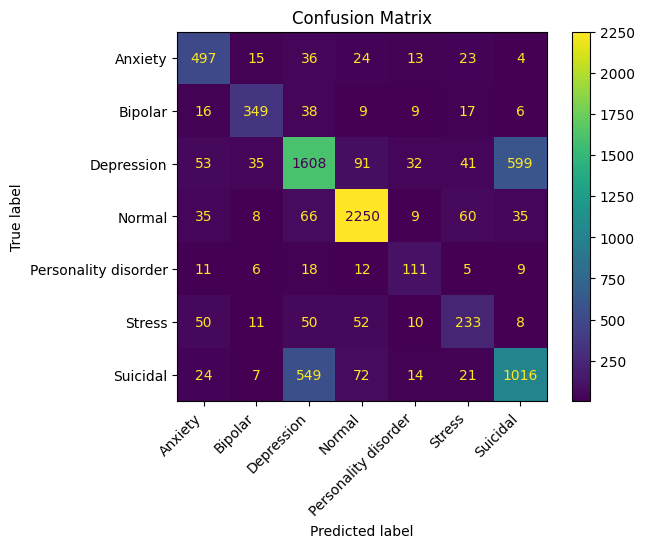

In [150]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay




pred_series = pd.Series(predicted_classes).map(lambda x: names[x]).to_numpy()
test_lebel_series = pd.Series(test_labels).map(lambda x: names[x]).to_numpy()



cm = confusion_matrix(test_lebel_series, pred_series)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_lebel_series))
disp.plot(cmap='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Confusion Matrix')
plt.show()



In [102]:
texts = ['i feel like i have a lot of things to do', 'i am very fearful and sweaty when i am around my boss',  'i am very anxious and sweaty when i am around my boss',
         'he is likely to die soon after all the suffering', 'i am very happy and i am in love', 'my gf of over 3 years dumped me, i feel stressed on how to start again',
         'I can see God and he gave me super powers. but this makes me feel low sometimes']

for text in texts:
  text = vectorizer([text])
  text = text.numpy()
  prediction = classifier.predict(text)
  index_predict = np.argmax(prediction)

  for value, status in enumerate(names):
    if value == index_predict:
      print(status)
      print(index_predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Normal
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Depression
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Anxiety
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Suicidal
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Normal
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Stress
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Normal
1


### Discussion and Observation

Observation:
Adjusting and fine-tuning parameters did not yield significant improvement (1%) improvement , with the best accuracy reaching 78%.

When tested with 7 sample text messages, the model correctly predicted 5 and missed 2. This suggests that the model performs reasonably well on larger classes like "Normal" and "Depression," but struggles with smaller, less represented classes unless specific terms are used.

A closer inspection of the dataset reveals that much of the text does not distinctly correspond to its assigned label. For example, a large portion of the "Depression" texts could easily be categorized as "Normal," indicating that the dataset contains a significant amount of noise.

Recommendation:
- Acquire additional training data to better balance the classes.
- Clean the dataset to remove irrelevant or noisy samples.
- Further analyze attention scores to identify key text features that influence predictions.

Interestingly, another analysis by Muhammad Faizan, who split the data into training and validation sets only and applied data augmentation, achieved an accuracy of 86%, the highest observed so far.